<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

# Exploratory Data Analysis

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

# Reading data and basic stats 

In [3]:
df = pd.read_csv("train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [5]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


We are given a minimal number of data fields here, consisting of:


    id: Looks like a simple rowID
    qid{1, 2}: The unique ID of each question in the pair
    question{1, 2}: The actual textual contents of the questions.
    is_duplicate: The label that we are trying to predict - whether the two questions are duplicates of each other.

# Distribution of data points among output classes

- Number of duplicate(smilar) and non-duplicate(non similar) questions

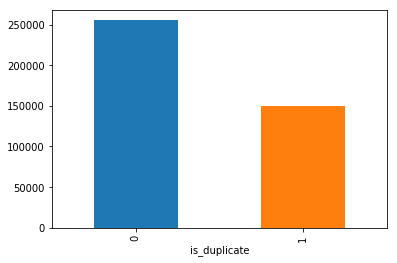

In [6]:
df.groupby("is_duplicate")['id'].count().plot.bar()

# Observation.

- Here we can see that number of question pairs which are not duplicates are more than the duplicate question pair.


In [7]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [8]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


# Number of unique questions

In [9]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



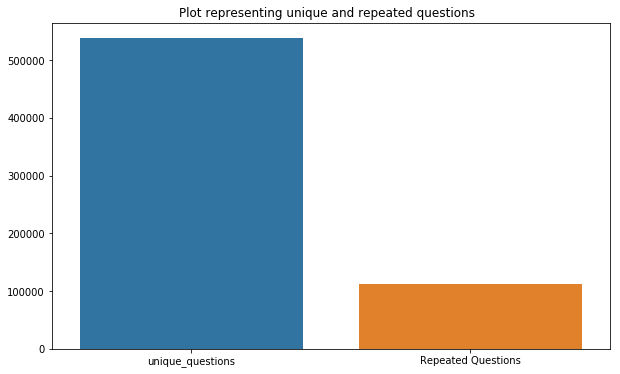

In [10]:

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

# Observation.

- Number of unique questions are more than the repeated one's.

# Checking for Duplicates

In [11]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


# Number of occurrences of each question 

Maximum number of times a single question is repeated: 157



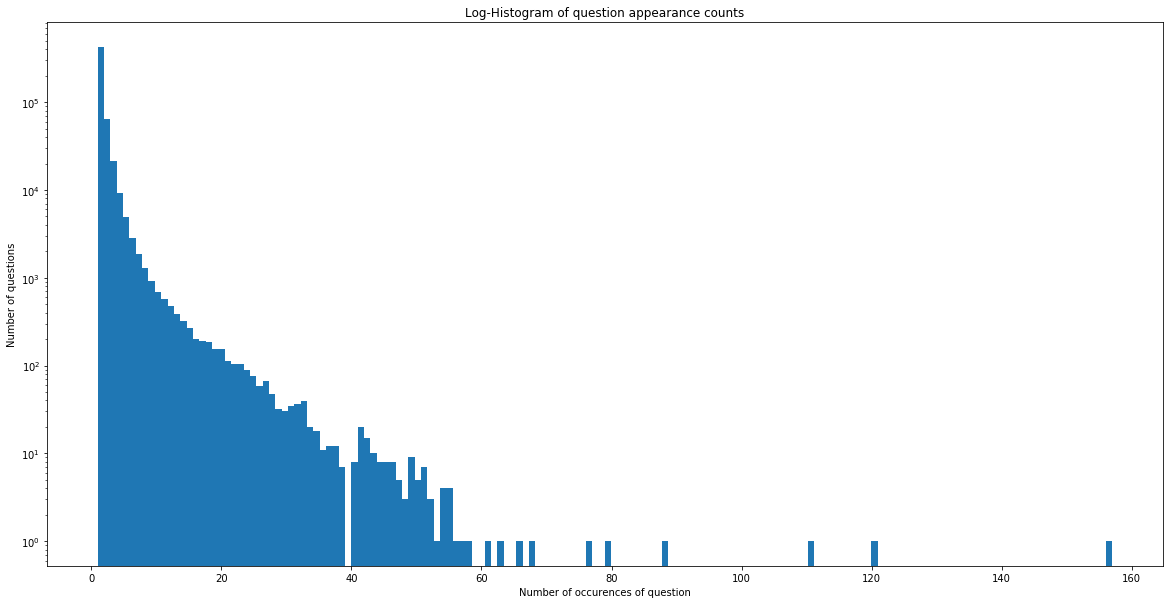

In [12]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

# Observation.

- Number of questions that occur one or two times is more than the rest of the questions.
- There is a single question that has occured 157 times.

# Checking for NULL values 

In [13]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


- There are two rows with null values in question2 

In [14]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


#  Basic Feature Extraction (before cleaning)

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [15]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


#  Analysis of some of the extracted features 

- Here are some questions have only one single words.

In [16]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


# Feature: word_share 

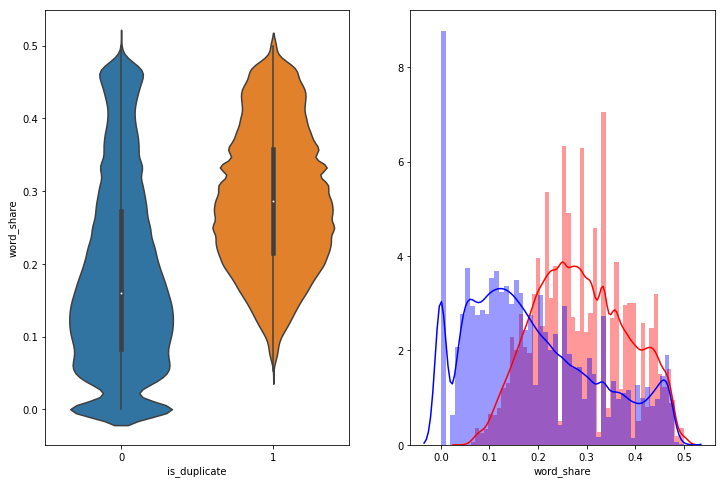

In [17]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

# Feature: word_Common 

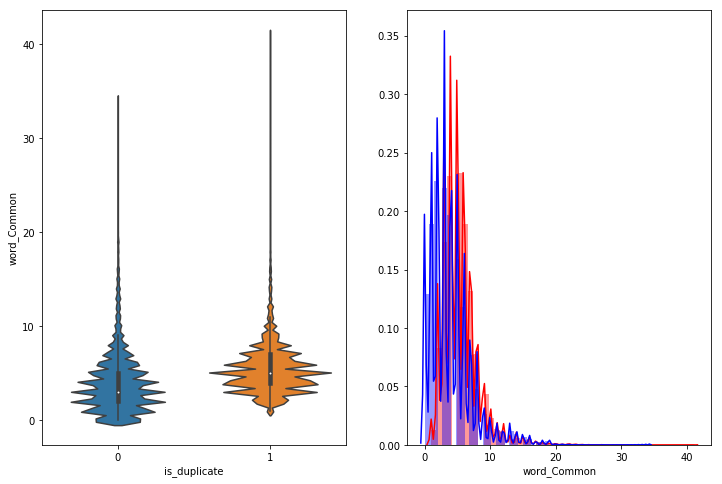

In [18]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

The distributions of the word_Common feature in similar and non-similar questions are highly overlapping 

# EDA: Advanced Feature Extraction.


In [19]:
#https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

In [20]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


# Preprocessing of Text 

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [21]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

# Advanced Feature Extraction (NLP and Fuzzy Features)

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [22]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [23]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


#  Analysis of extracted features

  -Plotting Word clouds

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [24]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s',encoding = 'utf8')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [35]:
import path

In [ ]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

__ Word Clouds generated from duplicate pair question's text __

Word Cloud for Duplicate Question pairs


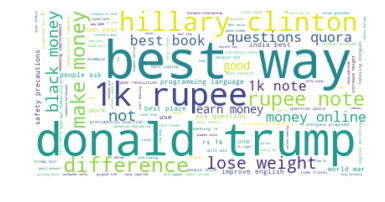

In [91]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# Observation.
- Word cloud for duplicate question pairs represents the words more that are related to political senario.


__ Word Clouds generated from non duplicate pair question's text __

Word Cloud for non-Duplicate Question pairs:


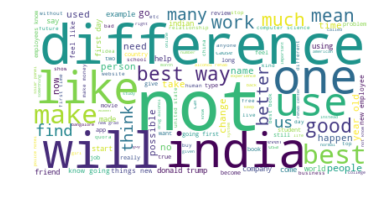

In [92]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# Observation.
- word cloud for non-duplicate question pairs represent some random words often.

# Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] 


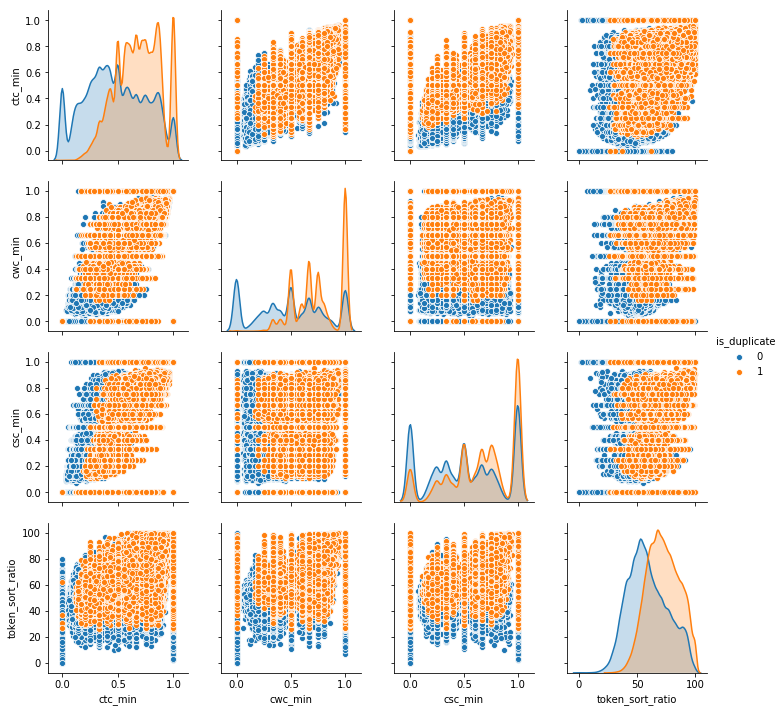

In [93]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()


# Observation .

- Here we can see that there is noticible overlap between duplicate and non duplicate question pair.
- But if we see  distribution between features such as (csc_min and ctc_min)and features (token_sort_ratio and csc_min) there is partial separatibilty between duplicate and non duplicate question pair.
- But the distribution of the duplicate question pair is quite more than the non duplicate question pair.

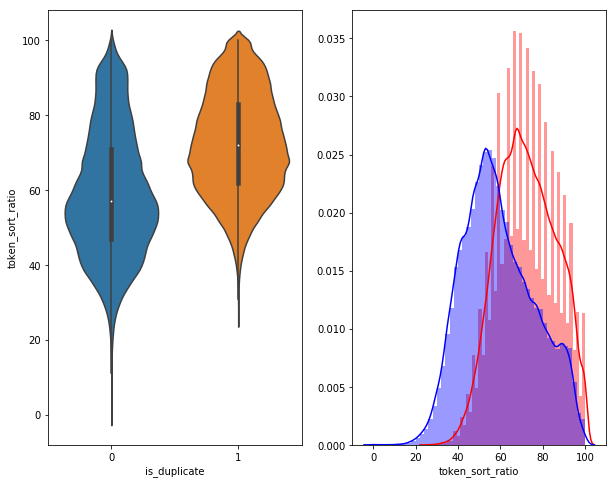

In [94]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

# Observation.

- After looking at the plots we can say that there is some overllap between token_sort_ratio of both duplicate and and non dupliacte question pair.
- But the value of token_sort_ratio of duplicate question pairs is more than non duplicate one's.

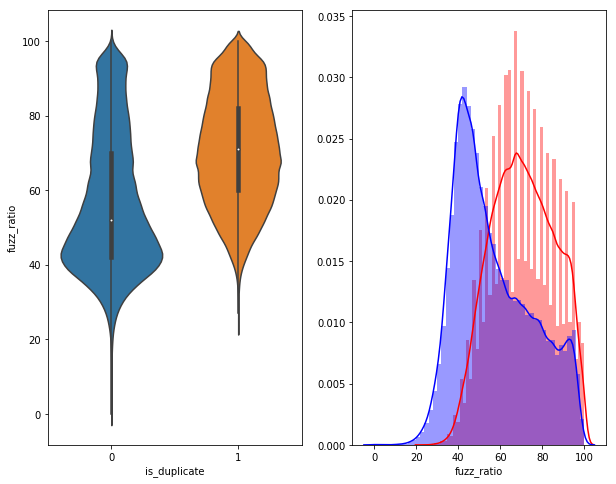

In [95]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

# Observation.

- After looking at the plots we can say that there is some overllap between fuzz_ratio of both duplicate and and non dupliacte question pair.
- But the value of fuzz_ratio of duplicate question pairs is more than non duplicate one's.

# Visualization 

In [96]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [97]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.009s...
[t-SNE] Computed neighbors for 5000 samples in 0.299s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.235s
[t-SNE] Iteration 50: error = 80.9162369, gradient norm = 0.0427600 (50 iterations in 2.074s)
[t-SNE] Iteration 100: error = 70.3915100, gradient norm = 0.0108003 (50 iterations in 1.530s)
[t-SNE] Iteration 150: error = 68.6126938, gradient norm = 0.0054721 (50 iterations in 1.519s)
[t-SNE] Iteration 200: error = 67.7680206, gradient norm = 0.0042246 (50 iterations in 1.573s)
[t-SNE] Iteration 250: error = 67.2733459, gradient norm = 0.0037275

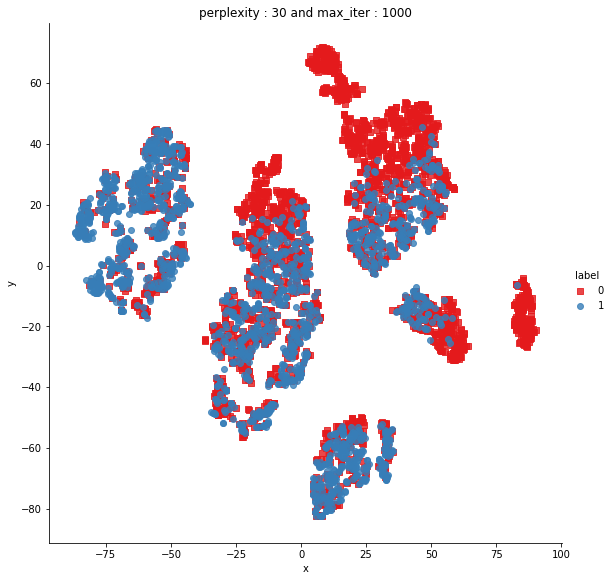

In [98]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

# Observation.

- Here we have projected 15 dimensional feature to 2 dimension..
- and we can notice that there is considerble amount of overlap.
- But there is some separatibilty too in the plot from here we can conclude that we have desinged 15 useful features

In [99]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.010s...
[t-SNE] Computed neighbors for 5000 samples in 0.302s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.200s
[t-SNE] Iteration 50: error = 80.3552017, gradient norm = 0.0329941 (50 iterations in 7.348s)
[t-SNE] Iteration 100: error = 69.1100388, gradient norm = 0.0034323 (50 iterations in 4.040s)
[t-SNE] Iteration 150: error = 67.6163483, gradient norm = 0.0017810 (50 iterations in 3.610s)
[t-SNE] Iteration 200: error = 67.0578613, gradient norm = 0.0011246 (50 iterations in 3.581s)
[t-SNE] Iteration 250: error = 66.7297821, gradient norm = 0.0009272

In [37]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

# Removing the stopwords from question 1 and question 2. 


In [100]:
# avoid decoding problems
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [101]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [102]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [103]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [104]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_question1 = []
# tqdm is for printing the status bar
for sentance in tqdm(df['question1'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_question1.append(sent.lower().strip())

100%|███████████████████████████████████████████████████████████████████████| 404290/404290 [00:11<00:00, 35429.20it/s]


In [105]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_question2 = []
# tqdm is for printing the status bar
for sentance in tqdm(df['question2'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_question2.append(sent.lower().strip())

100%|███████████████████████████████████████████████████████████████████████| 404290/404290 [00:11<00:00, 34822.92it/s]


In [106]:
df_1 = pd.read_csv("nlp_features_train.csv",encoding='latin-1')

In [107]:
df_1.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,...,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


# Summary.

- Here we have removed the stopwords from both question 1 and question 2.

In [108]:
df_1['preprocessed_question1'] = preprocessed_question1 
df_1.drop(['question1'], axis=1, inplace=True)


In [109]:
df_1['preprocessed_question2'] = preprocessed_question2
df_1.drop(['question2'], axis=1, inplace=True)


In [110]:
df_1.head(4)

,id,qid1,qid2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,...,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,preprocessed_question1,preprocessed_question2
0,0,1,2,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,...,1.0,2.0,13.0,100,93,93,100,0.982759,what step step guide invest share market india,what step step guide invest share market
1,1,3,4,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,...,1.0,5.0,12.5,86,63,66,75,0.596154,what story kohinoor koh noor diamond,what would happen indian government stole kohi...
2,2,5,6,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,...,1.0,4.0,12.0,66,66,54,54,0.166667,how i increase speed internet connection using...,how internet speed increased hacking dns
3,3,7,8,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,2.0,12.0,36,36,35,40,0.039216,why i mentally lonely how i solve,find remainder math 23 24 math divided 24 23


In [114]:
df1 = df_1.drop(['qid1','qid2'],axis=1)

In [115]:
df1.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,preprocessed_question1,preprocessed_question2
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759,what step step guide invest share market india,what step step guide invest share market
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154,what story kohinoor koh noor diamond,what would happen indian government stole kohi...
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667,how i increase speed internet connection using...,how internet speed increased hacking dns
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216,why i mentally lonely how i solve,find remainder math 23 24 math divided 24 23
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000,which one dissolve water quikly sugar salt met...,which fish would survive salt water


In [111]:

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [112]:
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

In [113]:
df2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [116]:
if not os.path.isfile('final_features1.csv'): 
    df1  = df1.merge(df2, on='id',how='left')
    df1.to_csv('final_features1.csv')

In [3]:
final_features = pd.read_csv("final_features1.csv",encoding='latin-1')

In [4]:
final_features.head()

,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,...,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,...,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,...,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,...,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [5]:
final_features.shape

(404290, 31)

# Taking  100k random data from the final features.

In [7]:
#https://stackoverflow.com/questions/53369669/selecting-random-rows-of-data-from-dataframe-csv-file-in-python-after-design

import random
a=random.sample(range(0,404290), 100000)
data = final_features.loc[a]

In [8]:
data.head()

,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
249976,249976,249976,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,1,67,49,16,10,0.0,23.0,0.000000,3,1
86784,86784,86784,1,0.999967,0.999967,0.999967,0.999967,0.999983,0.999983,0.0,...,1,33,33,6,6,4.0,12.0,0.333333,2,0
306122,306122,306122,0,0.666656,0.571420,0.833319,0.714276,0.692302,0.599996,1.0,...,1,74,66,15,13,9.0,26.0,0.346154,2,0
294588,294588,294588,1,0.999950,0.666644,0.199996,0.166664,0.428565,0.333330,1.0,...,8,30,41,7,8,3.0,15.0,0.200000,26,10
25377,25377,25377,0,0.000000,0.000000,0.666656,0.666656,0.444440,0.399996,0.0,...,5,43,37,10,9,4.0,19.0,0.210526,6,4


# Summary.

- Here we have taken random 100k points from the dataset

In [9]:
data.shape

(100000, 31)

In [11]:
if not os.path.isfile('data.csv'): 
    data.to_csv('data.csv')

In [7]:
data = pd.read_csv("data.csv",encoding='latin-1')

# Random train test Splitt.

In [8]:
y_is_duplicate = data['is_duplicate']

In [9]:
data.drop(['Unnamed: 0','is_duplicate'], axis=1, inplace=True)

In [10]:
data.drop(['Unnamed: 0.1'], axis=1, inplace=True)

In [11]:
data.head(2)

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,249976,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,4.0,...,1,67,49,16,10,0.0,23.0,0.000000,3,1
1,86784,0.999967,0.999967,0.999967,0.999967,0.999983,0.999983,0.0,1.0,0.0,...,1,33,33,6,6,4.0,12.0,0.333333,2,0


In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data,y_is_duplicate, test_size=0.20, stratify = y_is_duplicate)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.20, stratify=y_train)

# Observation.

- Here we have splitted the data in to train , test and cv.
- Test accounts for 20% of entire 100k points.
- CV accounts for 20%of train data set points.
- Train accounts for the remaning data set

In [14]:

print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)

(64000, 29) (64000,)
(16000, 29) (16000,)
(20000, 29) (20000,)


In [15]:
print(X_train['preprocessed_question1'][:7]) 

69037                             how i ask question quora
86642    i experience one year telecom domain billing t...
8010       how i get someone quora answer question quickly
32970    why girlfriend 7 years dont reply text calls s...
96753    what difference libertarian republican liberta...
55609                             can love without respect
10624                  what scope me transport engineering
Name: preprocessed_question1, dtype: object


In [16]:
print(X_train['preprocessed_question2'][:7])

69037                                  add questions quora
86642              why michael morpurgo write inspirations
8010                  how i get questions answered quickly
32970    why google providing unlimited storage videos ...
96753               what differences republicans democrats
55609                     how feel someone care walks life
10624                what scope transportation engineering
Name: preprocessed_question2, dtype: object


In [17]:
print(X_test['preprocessed_question1'][:7]) 

83173                    in future india pakistan together
58436                     how erectile dysfunction treated
62039                         when facebook launched india
56478     what difference monoclonal polyclonal antibodies
80446    should i buy lg k10 huawei p8 lite because rig...
25975                         when solarcity come illinois
35110           which best books learn html css javascript
Name: preprocessed_question1, dtype: object


In [18]:
print(X_test['preprocessed_question2'][:7])

83173                           could india pakistan unite
58436    how i overcome erectile dysfunction due mastur...
62039                  which sarcastic facebook page india
56478                   how monoclonal antibodies produced
80446    should i buy lg k10 huawei p8 lite cause right...
25975                 why tesla motors acquiring solarcity
35110                  what best books html css javascript
Name: preprocessed_question2, dtype: object


In [19]:
id1  = pd.DataFrame(columns = ['id'])

In [20]:
id1['id'] = X_train['id']

In [21]:
id1 = id1.reset_index(drop = True)

In [22]:
id2 = pd.DataFrame(columns = ['id'])
id2['id'] = X_test['id']
id2 = id2.reset_index(drop = True)

In [23]:
id3 = pd.DataFrame(columns = ['id'])
id3['id'] = X_cv['id']
id3 = id3.reset_index(drop = True)

In [24]:
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
X_train['preprocessed_question1'] = X_train['preprocessed_question1'].apply(lambda x: str(x))
X_train['preprocessed_question2'] = X_train['preprocessed_question2'].apply(lambda x: str(x))
X_cv['preprocessed_question1'] = X_cv['preprocessed_question1'].apply(lambda x: str(x))
X_cv['preprocessed_question2'] = X_cv['preprocessed_question2'].apply(lambda x: str(x))
X_test['preprocessed_question1'] = X_test['preprocessed_question1'].apply(lambda x: str(x))
X_test['preprocessed_question2'] = X_test['preprocessed_question2'].apply(lambda x: str(x))

# TFIDF vectorizer

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer_question1 = TfidfVectorizer(ngram_range=(1,2),min_df=10,max_features=5000)
tfidf_vectorizer_question1.fit(X_train['preprocessed_question1'].values.astype('U')) 

# we use the fitted CountVectorizer to convert the text to vector
X_train_question1_tfidf = tfidf_vectorizer_question1.transform(X_train['preprocessed_question1'].values.astype('U'))
X_cv_question1_tfidf = tfidf_vectorizer_question1.transform(X_cv['preprocessed_question1'].values.astype('U'))
X_test_question1_tfidf = tfidf_vectorizer_question1.transform(X_test['preprocessed_question1'].values.astype('U'))


print("After vectorizations")
print(X_train_question1_tfidf.shape, y_train.shape)
print(X_cv_question1_tfidf.shape, y_cv.shape)
print(X_test_question1_tfidf.shape, y_test.shape)
print("="*100)


After vectorizations
(64000, 5000) (64000,)
(16000, 5000) (16000,)
(20000, 5000) (20000,)


In [26]:
word2tfidf = dict(zip(tfidf_vectorizer_question1.get_feature_names(), tfidf_vectorizer_question1.idf_))

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer_question2 = TfidfVectorizer(ngram_range=(1,2),min_df=10,max_features=5000)
tfidf_vectorizer_question2.fit(X_train['preprocessed_question2'].values.astype('U')) 

# we use the fitted CountVectorizer to convert the text to vector
X_train_question2_tfidf = tfidf_vectorizer_question1.transform(X_train['preprocessed_question2'].values.astype('U'))
X_cv_question2_tfidf = tfidf_vectorizer_question1.transform(X_cv['preprocessed_question2'].values.astype('U'))
X_test_question2_tfidf = tfidf_vectorizer_question1.transform(X_test['preprocessed_question2'].values.astype('U'))


print("After vectorizations")
print(X_train_question2_tfidf.shape, y_train.shape)
print(X_cv_question2_tfidf.shape, y_cv.shape)
print(X_test_question2_tfidf.shape, y_test.shape)
print("="*100)

After vectorizations
(64000, 5000) (64000,)
(16000, 5000) (16000,)
(20000, 5000) (20000,)


In [28]:
word2tfidf2 = dict(zip(tfidf_vectorizer_question2.get_feature_names(), tfidf_vectorizer_question2.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [29]:
from tqdm import tqdm

In [30]:
import spacy

In [31]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

train_spacy_question1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_train['preprocessed_question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    train_spacy_question1.append(mean_vec1)
print(len(train_spacy_question1))
print(len(train_spacy_question1[0]))
X_train['train_spacy_question1 '] = list(train_spacy_question1 )

100%|███████████████████████████████████████████████████████████████████████████| 64000/64000 [05:43<00:00, 186.17it/s]


64000
96


In [32]:
X = pd.DataFrame(columns = ['q1'])

In [33]:
X['q1'] = list(train_spacy_question1)

In [34]:
df1 = pd.DataFrame(X.q1.values.tolist(), index= X.index)


In [35]:
df1.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,56.974754,-31.623169,14.776418,-0.879497,-16.202668,-22.032604,-18.037917,1.154812,-24.922027,43.341039,...,1.161028,-11.510019,36.351368,16.284036,28.468915,-38.349554,-8.283130,10.162346,-51.667091,16.073039
1,176.677225,-213.915146,-14.932039,-158.530595,-90.732114,-8.960324,283.820893,-103.179232,-22.421912,71.075899,...,27.521815,-85.116325,98.911812,0.363785,-78.010644,-29.021590,-87.329728,-150.112067,-194.457375,167.392901
2,76.699665,-70.035066,15.191837,-49.940784,-102.144436,-15.694981,22.390395,-25.319034,-16.812109,95.599233,...,4.828237,-79.219523,50.029286,-0.466925,39.239693,-46.251133,16.834764,2.670921,-79.909320,24.553318
3,136.523648,-15.429150,-85.413874,-150.635408,-59.535120,-15.358825,124.861799,27.504731,-33.183406,71.192452,...,13.787080,-65.527649,87.195058,23.268555,3.689281,-25.115341,8.520035,11.133816,-9.498560,-96.616125
4,22.712608,-53.559079,36.844013,-13.790469,-35.385882,53.793468,52.376090,-28.695078,30.079976,27.908762,...,25.962602,16.436242,50.313645,6.391319,-23.814572,-15.129715,-5.620906,-49.030655,-11.044014,-7.499350


In [36]:
# en_vectors_web_lg, which includes over 1 million unique vectors.

train_spacy_question2 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_train['preprocessed_question2'])):
    doc1 = nlp(qu1)
   
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])

    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf2[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    train_spacy_question2.append(mean_vec1)
print(len(train_spacy_question2))
print(len(train_spacy_question2[0]))


100%|███████████████████████████████████████████████████████████████████████████| 64000/64000 [05:39<00:00, 188.77it/s]


64000
96


In [37]:
X['q2'] = list(train_spacy_question2)
df1_q2 = pd.DataFrame(X.q2.values.tolist(), index= X.index)


In [38]:
df1_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,92.216591,-0.422680,0.654497,-37.089756,1.257805,8.109902,33.833057,4.758631,-61.111459,30.567807,...,-4.656930,-19.022320,37.450969,-1.468994,34.655555,-33.111314,24.439209,42.026902,-15.794651,7.740181
1,-11.664124,-45.547011,7.039556,-40.808898,-4.718346,22.456544,37.825931,40.176334,-32.525370,27.702031,...,11.864881,1.155723,68.520517,20.647607,31.184997,6.503763,-32.444098,21.901840,-10.797011,26.748798
2,-28.798357,44.522765,-40.760744,-97.381515,-11.219553,14.699886,63.170661,-19.455305,34.802705,24.476797,...,71.986844,-19.107353,-39.783336,35.094915,-1.345363,13.028686,-18.535168,31.224399,-15.987473,21.603972
3,89.028887,1.845743,-62.888304,-114.988560,29.392665,-2.507640,212.573636,130.203555,-23.467432,40.042646,...,4.009461,1.689686,68.978542,-10.777313,-0.051342,33.925458,-35.751914,22.366190,-59.108962,20.617861
4,41.464449,-2.187628,46.464428,-37.105304,29.683248,66.545379,40.778179,13.012935,-45.721726,12.263576,...,6.163449,-4.522138,41.387422,101.222317,-21.522653,10.328700,-32.678128,56.437915,-14.072939,-85.813424


In [39]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

cv_spacy_question1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_cv['preprocessed_question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    cv_spacy_question1.append(mean_vec1)
print(len(cv_spacy_question1))
print(len(cv_spacy_question1[0]))


100%|███████████████████████████████████████████████████████████████████████████| 16000/16000 [01:24<00:00, 189.58it/s]


16000
96


In [40]:
X_cv_p = pd.DataFrame(columns = ['q1','q2'])

In [41]:
X_cv_p['q1'] = list(cv_spacy_question1)
df1_cv_q1 = pd.DataFrame(X_cv_p.q1.values.tolist(), index= X_cv_p.index)

In [42]:
df1_cv_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,59.687177,-82.273061,11.908227,-18.492747,-67.589800,-11.540278,44.035917,-17.629495,-13.211897,70.882702,...,29.496609,-44.566170,68.292881,-6.023789,17.405585,-3.584137,-10.364374,19.542979,-38.442099,46.116207
1,81.924910,-87.000760,11.355138,-75.792414,-13.300342,-2.560325,84.524909,-19.990759,-70.252487,11.176174,...,38.957206,-20.426381,133.993715,-9.205295,-18.583928,4.732218,21.963682,-53.860654,-31.980205,70.096653
2,25.193021,-52.508725,-25.021555,10.504304,-4.191151,60.193565,167.123106,86.909073,-46.117676,68.043599,...,31.646499,-19.172378,119.996794,-74.474511,3.118290,1.854102,-84.721060,-25.850471,-78.941145,46.571242
3,8.606141,-18.577521,31.413889,-2.584588,-0.462524,3.326608,-2.805450,-15.572844,-14.860098,17.238973,...,9.451685,4.841186,18.360368,4.304807,-7.915113,2.805986,-12.691877,-10.342142,-11.796766,23.969048
4,14.983792,3.648064,14.873043,-32.074179,39.179834,4.690898,18.077334,17.202317,-22.611732,11.647635,...,-14.801582,-8.643657,46.531338,26.562077,3.045952,-0.975125,-16.685344,9.692618,-32.323268,-35.929474


In [43]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

cv_spacy_question2 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_cv['preprocessed_question2'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    cv_spacy_question2.append(mean_vec1)
print(len(cv_spacy_question2))
print(len(cv_spacy_question2[0]))

100%|███████████████████████████████████████████████████████████████████████████| 16000/16000 [01:25<00:00, 187.69it/s]


16000
96


In [44]:
X_cv_p['q2'] = list(cv_spacy_question2)
df1_cv_q2 = pd.DataFrame(X_cv_p.q2.values.tolist(), index= X_cv_p.index)


In [45]:
df1_cv_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,25.326238,24.189224,5.418899,-39.574277,-9.872750,8.681405,10.020714,9.588297,-18.008789,59.331890,...,8.451600,-12.139462,17.375420,6.445427,3.435246,16.036283,-22.060206,24.840993,-30.439044,32.515541
1,3.186815,-89.824588,-48.142559,-46.535590,-57.219646,26.155191,74.549479,55.088539,-68.066885,17.479402,...,30.863419,-8.158773,72.177979,58.536397,42.248950,-17.825972,-60.228891,30.847685,-107.294236,-12.284249
2,83.090661,-81.747090,-9.324600,-14.550650,-29.253738,109.133101,213.499020,85.281560,-35.782839,53.136950,...,11.048149,-21.245236,151.696427,-122.693285,-1.784299,30.453756,-120.060885,-45.401713,-45.241808,56.666076
3,64.127439,-38.272177,45.661268,-23.902921,1.477121,26.016937,50.868970,-26.464650,-21.585388,32.404258,...,-8.694702,-26.030514,28.981996,-12.641704,-38.737745,-12.690025,18.404381,-18.834367,2.241466,42.317780
4,14.983792,3.648064,14.873043,-32.074179,39.179834,4.690898,18.077334,17.202317,-22.611732,11.647635,...,-14.801582,-8.643657,46.531338,26.562077,3.045952,-0.975125,-16.685344,9.692618,-32.323268,-35.929474


In [46]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

test_spacy_question1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_test['preprocessed_question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    test_spacy_question1.append(mean_vec1)
print(len(test_spacy_question1))
print(len(test_spacy_question1[0]))

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:46<00:00, 187.06it/s]


20000
96


In [47]:
X_test_p = pd.DataFrame(columns = ['q1','q2'])

In [48]:
X_test_p['q1'] = list(test_spacy_question1)
df1_test_q1 = pd.DataFrame(X_test_p.q1.values.tolist(), index= X_test_p.index)


In [49]:
df1_test_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,-30.270423,-39.519523,-108.662220,-81.606903,12.621193,50.149184,33.655077,10.805605,-59.768202,-19.524038,...,85.009750,-21.040132,17.641940,154.032180,23.514925,78.209238,-19.583012,61.478104,-24.672005,47.120638
1,-26.638857,-14.056952,2.719328,-10.069068,37.250597,8.738672,35.562140,11.153286,13.513415,-2.978835,...,45.363256,-2.043543,-4.123775,-6.168052,1.323461,-10.990523,20.962811,-8.742347,-13.360324,38.667372
2,21.084538,11.647778,-26.062578,-48.244839,9.380896,-2.737415,1.723608,-1.602966,-10.498632,-13.308736,...,23.931847,11.325625,11.975763,13.304633,3.131716,44.406233,-9.280729,-3.541378,-1.016658,28.631683
3,15.574602,-20.050781,32.887186,-16.266396,-2.622835,5.996462,11.751752,-2.848224,-20.566381,15.435878,...,18.219570,-7.004236,11.916079,15.773546,-7.397727,-5.856307,2.403455,-3.423841,-15.580758,2.100723
4,57.946009,-15.599013,-57.073038,-86.183156,-96.292097,48.682325,30.834947,81.225595,-86.226931,39.658463,...,-17.117440,-9.633052,64.579834,42.225615,-13.059535,14.919939,-8.673255,32.972147,-69.944161,59.065253


In [50]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

test_spacy_question2 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_test['preprocessed_question2'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf2[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    test_spacy_question2.append(mean_vec1)
print(len(test_spacy_question2))
print(len(test_spacy_question2[0]))

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:46<00:00, 188.55it/s]


20000
96


In [51]:
X_test_p['q2'] = list(test_spacy_question2)
df1_test_q2 = pd.DataFrame(X_test_p.q2.values.tolist(), index= X_test_p.index)


In [52]:
df1_test_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,11.770388,16.144778,-80.625439,-52.390652,-7.114415,14.478058,20.492794,-1.388729,-0.235572,-12.100637,...,63.108465,22.869392,74.774454,33.335279,10.593507,23.344418,39.444022,30.398507,-20.885468,33.360725
1,32.640379,-18.335547,-3.359427,-16.849875,-28.517915,40.601302,77.758918,-19.167663,-14.793452,-16.573127,...,43.435150,16.174818,52.417759,1.162170,-10.586572,-52.836027,-50.135520,18.064565,-22.286919,10.482822
2,73.831348,-61.556502,16.088057,-41.926080,16.779262,-12.994588,78.313874,-46.849531,-30.682608,64.903428,...,8.152620,-39.365529,83.758715,-17.113093,-22.596804,24.702381,-6.924561,-24.784601,-51.388985,8.102541
3,-4.894828,6.182382,4.815313,-11.180055,6.234278,-7.585938,-2.563668,-0.418991,8.490457,8.843120,...,7.530086,0.227851,1.901548,2.225986,-5.739512,5.360421,-7.408268,1.716194,5.994143,0.925694
4,16.682659,-56.074588,-114.757952,-84.462521,-111.485709,26.995821,28.361279,77.188112,-120.498176,27.624017,...,-12.069812,3.543800,109.199966,42.244495,-11.188801,72.590705,3.350864,16.454384,-111.420812,96.720500


# Standarising the numerical feature: cwc_min

# Reading the column names.

In [255]:
i = 1
for col in X_train.columns: 
    print(i,col) 
    i += 1

1 id
2 cwc_min
3 cwc_max
4 csc_min
5 csc_max
6 ctc_min
7 ctc_max
8 last_word_eq
9 first_word_eq
10 abs_len_diff
11 mean_len
12 token_set_ratio
13 token_sort_ratio
14 fuzz_ratio
15 fuzz_partial_ratio
16 longest_substr_ratio
17 preprocessed_question1
18 preprocessed_question2
19 freq_qid1
20 freq_qid2
21 q1len
22 q2len
23 q1_n_words
24 q2_n_words
25 word_Common
26 word_Total
27 word_share
28 freq_q1+q2
29 freq_q1-q2
30 train_spacy_question1 


In [53]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
# StandardScaler.fit(X_train['cwc_min'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
standardScaler.fit(X_train['cwc_min'].values.reshape(-1,1))

X_train_cwc_min_stand = standardScaler.transform(X_train['cwc_min'].values.reshape(-1,1))
X_cv_cwc_min_stand = standardScaler.transform(X_cv['cwc_min'].values.reshape(-1,1))
X_test_cwc_min_stand = standardScaler.transform(X_test['cwc_min'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_cwc_min_stand.shape, y_train.shape)
print(X_cv_cwc_min_stand.shape, y_cv.shape)
print(X_test_cwc_min_stand.shape, y_test.shape)
print("="*100)

After vectorizations
(64000, 1) (64000,)
(16000, 1) (16000,)
(20000, 1) (20000,)


# Standarising the numerical feature: cwc_max

In [54]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
# StandardScaler.fit(X_train['cwc_min'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
standardScaler.fit(X_train['cwc_max'].values.reshape(-1,1))

X_train_cwc_max_stand = standardScaler.transform(X_train['cwc_max'].values.reshape(-1,1))
X_cv_cwc_max_stand = standardScaler.transform(X_cv['cwc_max'].values.reshape(-1,1))
X_test_cwc_max_stand = standardScaler.transform(X_test['cwc_max'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_cwc_max_stand.shape, y_train.shape)
print(X_cv_cwc_max_stand.shape, y_cv.shape)
print(X_test_cwc_max_stand.shape, y_test.shape)
print("="*100)

After vectorizations
(64000, 1) (64000,)
(16000, 1) (16000,)
(20000, 1) (20000,)


# Standarising the numerical feature: csc_min

In [55]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
# StandardScaler.fit(X_train['cwc_min'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
standardScaler.fit(X_train['csc_min'].values.reshape(-1,1))

X_train_csc_min_stand = standardScaler.transform(X_train['csc_min'].values.reshape(-1,1))
X_cv_csc_min_stand = standardScaler.transform(X_cv['csc_min'].values.reshape(-1,1))
X_test_csc_min_stand = standardScaler.transform(X_test['csc_min'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_csc_min_stand.shape, y_train.shape)
print(X_cv_csc_min_stand.shape, y_cv.shape)
print(X_test_csc_min_stand.shape, y_test.shape)
print("="*100)

After vectorizations
(64000, 1) (64000,)
(16000, 1) (16000,)
(20000, 1) (20000,)


# Standarising the numerical feature: csc_max

In [56]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
# StandardScaler.fit(X_train['cwc_min'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
standardScaler.fit(X_train['csc_max'].values.reshape(-1,1))

X_train_csc_max_stand = standardScaler.transform(X_train['csc_max'].values.reshape(-1,1))
X_cv_csc_max_stand = standardScaler.transform(X_cv['csc_max'].values.reshape(-1,1))
X_test_csc_max_stand = standardScaler.transform(X_test['csc_max'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_csc_max_stand.shape, y_train.shape)
print(X_cv_csc_max_stand.shape, y_cv.shape)
print(X_test_csc_max_stand.shape, y_test.shape)
print("="*100)

After vectorizations
(64000, 1) (64000,)
(16000, 1) (16000,)
(20000, 1) (20000,)


# Standarising the numerical feature: ctc_min

In [57]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
# StandardScaler.fit(X_train['cwc_min'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
standardScaler.fit(X_train['ctc_min'].values.reshape(-1,1))

X_train_ctc_min_stand = standardScaler.transform(X_train['ctc_min'].values.reshape(-1,1))
X_cv_ctc_min_stand = standardScaler.transform(X_cv['ctc_min'].values.reshape(-1,1))
X_test_ctc_min_stand = standardScaler.transform(X_test['ctc_min'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_ctc_min_stand.shape, y_train.shape)
print(X_cv_ctc_min_stand.shape, y_cv.shape)
print(X_test_ctc_min_stand.shape, y_test.shape)
print("="*100)

After vectorizations
(64000, 1) (64000,)
(16000, 1) (16000,)
(20000, 1) (20000,)


# Standarising the numerical feature: ctc_max

In [58]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
# StandardScaler.fit(X_train['cwc_min'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
standardScaler.fit(X_train['ctc_max'].values.reshape(-1,1))

X_train_ctc_max_stand = standardScaler.transform(X_train['ctc_max'].values.reshape(-1,1))
X_cv_ctc_max_stand = standardScaler.transform(X_cv['ctc_max'].values.reshape(-1,1))
X_test_ctc_max_stand = standardScaler.transform(X_test['ctc_max'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_ctc_max_stand.shape, y_train.shape)
print(X_cv_ctc_max_stand.shape, y_cv.shape)
print(X_test_ctc_max_stand.shape, y_test.shape)
print("="*100)

After vectorizations
(64000, 1) (64000,)
(16000, 1) (16000,)
(20000, 1) (20000,)


# Standarising the numerical feature: last_word_eq

In [59]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
# StandardScaler.fit(X_train['cwc_min'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
standardScaler.fit(X_train['last_word_eq'].values.reshape(-1,1))

X_train_last_word_eq_stand = standardScaler.transform(X_train['last_word_eq'].values.reshape(-1,1))
X_cv_last_word_eq_stand = standardScaler.transform(X_cv['last_word_eq'].values.reshape(-1,1))
X_test_last_word_eq_stand = standardScaler.transform(X_test['last_word_eq'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_last_word_eq_stand.shape, y_train.shape)
print(X_cv_last_word_eq_stand.shape, y_cv.shape)
print(X_test_last_word_eq_stand.shape, y_test.shape)
print("="*100)

After vectorizations
(64000, 1) (64000,)
(16000, 1) (16000,)
(20000, 1) (20000,)


# Standarising the numerical feature: first_word_eq

In [60]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
# StandardScaler.fit(X_train['cwc_min'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
standardScaler.fit(X_train['first_word_eq'].values.reshape(-1,1))

X_train_first_word_eq_stand = standardScaler.transform(X_train['first_word_eq'].values.reshape(-1,1))
X_cv_first_word_eq_stand = standardScaler.transform(X_cv['first_word_eq'].values.reshape(-1,1))
X_test_first_word_eq_stand = standardScaler.transform(X_test['first_word_eq'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_first_word_eq_stand.shape, y_train.shape)
print(X_cv_first_word_eq_stand.shape, y_cv.shape)
print(X_test_first_word_eq_stand.shape, y_test.shape)
print("="*100)

After vectorizations
(64000, 1) (64000,)
(16000, 1) (16000,)
(20000, 1) (20000,)


# Standarising the numerical feature: abs_len_diff

In [61]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
# StandardScaler.fit(X_train['cwc_min'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
standardScaler.fit(X_train['abs_len_diff'].values.reshape(-1,1))

X_train_abs_len_diff_stand = standardScaler.transform(X_train['abs_len_diff'].values.reshape(-1,1))
X_cv_abs_len_diff_stand = standardScaler.transform(X_cv['abs_len_diff'].values.reshape(-1,1))
X_test_abs_len_diff_stand = standardScaler.transform(X_test['abs_len_diff'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_abs_len_diff_stand.shape, y_train.shape)
print(X_cv_abs_len_diff_stand.shape, y_cv.shape)
print(X_test_abs_len_diff_stand.shape, y_test.shape)
print("="*100)

After vectorizations
(64000, 1) (64000,)
(16000, 1) (16000,)
(20000, 1) (20000,)


# Standarising the numerical feature: mean_len

In [62]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
# StandardScaler.fit(X_train['cwc_min'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
standardScaler.fit(X_train['mean_len'].values.reshape(-1,1))

X_train_mean_len_stand = standardScaler.transform(X_train['mean_len'].values.reshape(-1,1))
X_cv_mean_len_stand = standardScaler.transform(X_cv['mean_len'].values.reshape(-1,1))
X_test_mean_len_stand = standardScaler.transform(X_test['mean_len'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_mean_len_stand.shape, y_train.shape)
print(X_cv_mean_len_stand.shape, y_cv.shape)
print(X_test_mean_len_stand.shape, y_test.shape)
print("="*100)

After vectorizations
(64000, 1) (64000,)
(16000, 1) (16000,)
(20000, 1) (20000,)


# Standarising the numerical feature: token_set_ratio

In [63]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
# StandardScaler.fit(X_train['cwc_min'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
standardScaler.fit(X_train['token_set_ratio'].values.reshape(-1,1))

X_train_token_set_ratio_stand = standardScaler.transform(X_train['token_set_ratio'].values.reshape(-1,1))
X_cv_token_set_ratio_stand = standardScaler.transform(X_cv['token_set_ratio'].values.reshape(-1,1))
X_test_token_set_ratio_stand = standardScaler.transform(X_test['token_set_ratio'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_token_set_ratio_stand.shape, y_train.shape)
print(X_cv_token_set_ratio_stand.shape, y_cv.shape)
print(X_test_token_set_ratio_stand.shape, y_test.shape)
print("="*100)

After vectorizations
(64000, 1) (64000,)
(16000, 1) (16000,)
(20000, 1) (20000,)


# Standarising the numerical feature: token_sort_ratio

In [64]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
# StandardScaler.fit(X_train['cwc_min'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
standardScaler.fit(X_train['token_sort_ratio'].values.reshape(-1,1))

X_train_token_sort_ratio_stand = standardScaler.transform(X_train['token_sort_ratio'].values.reshape(-1,1))
X_cv_token_sort_ratio_stand = standardScaler.transform(X_cv['token_sort_ratio'].values.reshape(-1,1))
X_test_token_sort_ratio_stand = standardScaler.transform(X_test['token_sort_ratio'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_token_sort_ratio_stand.shape, y_train.shape)
print(X_cv_token_sort_ratio_stand.shape, y_cv.shape)
print(X_test_token_sort_ratio_stand.shape, y_test.shape)
print("="*100)

After vectorizations
(64000, 1) (64000,)
(16000, 1) (16000,)
(20000, 1) (20000,)


# Standarising the numerical feature: fuzz_ratio

In [65]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
# StandardScaler.fit(X_train['cwc_min'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
standardScaler.fit(X_train['fuzz_ratio'].values.reshape(-1,1))

X_train_fuzz_ratio_stand = standardScaler.transform(X_train['fuzz_ratio'].values.reshape(-1,1))
X_cv_fuzz_ratio_stand = standardScaler.transform(X_cv['fuzz_ratio'].values.reshape(-1,1))
X_test_fuzz_ratio_stand = standardScaler.transform(X_test['fuzz_ratio'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_fuzz_ratio_stand.shape, y_train.shape)
print(X_cv_fuzz_ratio_stand.shape, y_cv.shape)
print(X_test_fuzz_ratio_stand.shape, y_test.shape)
print("="*100)

After vectorizations
(64000, 1) (64000,)
(16000, 1) (16000,)
(20000, 1) (20000,)


# Standarising the numerical feature: fuzz_partial_ratio

In [66]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
# StandardScaler.fit(X_train['cwc_min'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
standardScaler.fit(X_train['fuzz_partial_ratio'].values.reshape(-1,1))

X_train_fuzz_partial_ratio_stand = standardScaler.transform(X_train['fuzz_partial_ratio'].values.reshape(-1,1))
X_cv_fuzz_partial_ratio_stand = standardScaler.transform(X_cv['fuzz_partial_ratio'].values.reshape(-1,1))
X_test_fuzz_partial_ratio_stand = standardScaler.transform(X_test['fuzz_partial_ratio'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_fuzz_partial_ratio_stand.shape, y_train.shape)
print(X_cv_fuzz_partial_ratio_stand.shape, y_cv.shape)
print(X_test_fuzz_partial_ratio_stand.shape, y_test.shape)
print("="*100)

After vectorizations
(64000, 1) (64000,)
(16000, 1) (16000,)
(20000, 1) (20000,)


# Standarising the numerical feature: longest_substr_ratio

In [67]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
# StandardScaler.fit(X_train['cwc_min'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
standardScaler.fit(X_train['longest_substr_ratio'].values.reshape(-1,1))

X_train_longest_substr_ratio_stand = standardScaler.transform(X_train['longest_substr_ratio'].values.reshape(-1,1))
X_cv_longest_substr_ratio_stand = standardScaler.transform(X_cv['longest_substr_ratio'].values.reshape(-1,1))
X_test_longest_substr_ratio_stand = standardScaler.transform(X_test['longest_substr_ratio'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_longest_substr_ratio_stand.shape, y_train.shape)
print(X_cv_longest_substr_ratio_stand.shape, y_cv.shape)
print(X_test_longest_substr_ratio_stand.shape, y_test.shape)
print("="*100)

After vectorizations
(64000, 1) (64000,)
(16000, 1) (16000,)
(20000, 1) (20000,)


# Standarising the numerical feature: freq_qid1

In [68]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
# StandardScaler.fit(X_train['cwc_min'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
standardScaler.fit(X_train['freq_qid1'].values.reshape(-1,1))

X_train_freq_qid1_stand = standardScaler.transform(X_train['freq_qid1'].values.reshape(-1,1))
X_cv_freq_qid1_stand = standardScaler.transform(X_cv['freq_qid1'].values.reshape(-1,1))
X_test_freq_qid1_stand = standardScaler.transform(X_test['freq_qid1'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_freq_qid1_stand.shape, y_train.shape)
print(X_cv_freq_qid1_stand.shape, y_cv.shape)
print(X_test_freq_qid1_stand.shape, y_test.shape)
print("="*100)

After vectorizations
(64000, 1) (64000,)
(16000, 1) (16000,)
(20000, 1) (20000,)


# Standarising the numerical feature: freq_qid2

In [69]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
# StandardScaler.fit(X_train['cwc_min'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
standardScaler.fit(X_train['freq_qid2'].values.reshape(-1,1))

X_train_freq_qid2_stand = standardScaler.transform(X_train['freq_qid2'].values.reshape(-1,1))
X_cv_freq_qid2_stand = standardScaler.transform(X_cv['freq_qid2'].values.reshape(-1,1))
X_test_freq_qid2_stand = standardScaler.transform(X_test['freq_qid2'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_freq_qid2_stand.shape, y_train.shape)
print(X_cv_freq_qid2_stand.shape, y_cv.shape)
print(X_test_freq_qid2_stand.shape, y_test.shape)
print("="*100)

After vectorizations
(64000, 1) (64000,)
(16000, 1) (16000,)
(20000, 1) (20000,)


# Standarising the numerical feature: q1len

In [70]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
# StandardScaler.fit(X_train['cwc_min'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
standardScaler.fit(X_train['q1len'].values.reshape(-1,1))

X_train_q1len_stand = standardScaler.transform(X_train['q1len'].values.reshape(-1,1))
X_cv_q1len_stand = standardScaler.transform(X_cv['q1len'].values.reshape(-1,1))
X_test_q1len_stand = standardScaler.transform(X_test['q1len'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_q1len_stand.shape, y_train.shape)
print(X_cv_q1len_stand.shape, y_cv.shape)
print(X_test_q1len_stand.shape, y_test.shape)
print("="*100)

After vectorizations
(64000, 1) (64000,)
(16000, 1) (16000,)
(20000, 1) (20000,)


# Standarising the numerical feature: q2len

In [71]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
# StandardScaler.fit(X_train['cwc_min'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
standardScaler.fit(X_train['q2len'].values.reshape(-1,1))

X_train_q2len_stand = standardScaler.transform(X_train['q2len'].values.reshape(-1,1))
X_cv_q2len_stand = standardScaler.transform(X_cv['q2len'].values.reshape(-1,1))
X_test_q2len_stand = standardScaler.transform(X_test['q2len'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_q2len_stand.shape, y_train.shape)
print(X_cv_q2len_stand.shape, y_cv.shape)
print(X_test_q2len_stand.shape, y_test.shape)
print("="*100)

After vectorizations
(64000, 1) (64000,)
(16000, 1) (16000,)
(20000, 1) (20000,)


# Standarising the numerical feature: q1_n_words

In [72]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
# StandardScaler.fit(X_train['cwc_min'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
standardScaler.fit(X_train['q1_n_words'].values.reshape(-1,1))

X_train_q1_n_words_stand = standardScaler.transform(X_train['q1_n_words'].values.reshape(-1,1))
X_cv_q1_n_words_stand = standardScaler.transform(X_cv['q1_n_words'].values.reshape(-1,1))
X_test_q1_n_words_stand = standardScaler.transform(X_test['q1_n_words'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_q1_n_words_stand.shape, y_train.shape)
print(X_cv_q1_n_words_stand.shape, y_cv.shape)
print(X_test_q1_n_words_stand.shape, y_test.shape)
print("="*100)

After vectorizations
(64000, 1) (64000,)
(16000, 1) (16000,)
(20000, 1) (20000,)


# Standarising the numerical feature:q2_n_words

In [73]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
# StandardScaler.fit(X_train['cwc_min'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
standardScaler.fit(X_train['q2_n_words'].values.reshape(-1,1))

X_train_q2_n_words_stand = standardScaler.transform(X_train['q2_n_words'].values.reshape(-1,1))
X_cv_q2_n_words_stand = standardScaler.transform(X_cv['q2_n_words'].values.reshape(-1,1))
X_test_q2_n_words_stand = standardScaler.transform(X_test['q2_n_words'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_q2_n_words_stand.shape, y_train.shape)
print(X_cv_q2_n_words_stand.shape, y_cv.shape)
print(X_test_q2_n_words_stand.shape, y_test.shape)
print("="*100)

After vectorizations
(64000, 1) (64000,)
(16000, 1) (16000,)
(20000, 1) (20000,)


# Standarising the numerical feature:word_Common

In [74]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
# StandardScaler.fit(X_train['cwc_min'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
standardScaler.fit(X_train['word_Common'].values.reshape(-1,1))

X_train_word_Common_stand = standardScaler.transform(X_train['word_Common'].values.reshape(-1,1))
X_cv_word_Common_stand = standardScaler.transform(X_cv['word_Common'].values.reshape(-1,1))
X_test_word_Common_stand = standardScaler.transform(X_test['word_Common'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_word_Common_stand.shape, y_train.shape)
print(X_cv_word_Common_stand.shape, y_cv.shape)
print(X_test_word_Common_stand.shape, y_test.shape)
print("="*100)

After vectorizations
(64000, 1) (64000,)
(16000, 1) (16000,)
(20000, 1) (20000,)


# Standarising the numerical feature:word_Total

In [75]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
# StandardScaler.fit(X_train['cwc_min'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
standardScaler.fit(X_train['word_Total'].values.reshape(-1,1))

X_train_word_Total_stand = standardScaler.transform(X_train['word_Total'].values.reshape(-1,1))
X_cv_word_Total_stand = standardScaler.transform(X_cv['word_Total'].values.reshape(-1,1))
X_test_word_Total_stand = standardScaler.transform(X_test['word_Total'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_word_Total_stand.shape, y_train.shape)
print(X_cv_word_Total_stand.shape, y_cv.shape)
print(X_test_word_Total_stand.shape, y_test.shape)
print("="*100)

After vectorizations
(64000, 1) (64000,)
(16000, 1) (16000,)
(20000, 1) (20000,)


# Standarising the numerical feature:word_share

In [76]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
# StandardScaler.fit(X_train['cwc_min'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
standardScaler.fit(X_train['word_share'].values.reshape(-1,1))

X_train_word_share_stand = standardScaler.transform(X_train['word_share'].values.reshape(-1,1))
X_cv_word_share_stand = standardScaler.transform(X_cv['word_share'].values.reshape(-1,1))
X_test_word_share_stand = standardScaler.transform(X_test['word_share'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_word_share_stand.shape, y_train.shape)
print(X_cv_word_share_stand.shape, y_cv.shape)
print(X_test_word_share_stand.shape, y_test.shape)
print("="*100)

After vectorizations
(64000, 1) (64000,)
(16000, 1) (16000,)
(20000, 1) (20000,)


# Standarising the numerical feature:freq_q1+q2

In [77]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
# StandardScaler.fit(X_train['cwc_min'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
standardScaler.fit(X_train['freq_q1+q2'].values.reshape(-1,1))

X_train_freq_q1q2_stand = standardScaler.transform(X_train['freq_q1+q2'].values.reshape(-1,1))
X_cv_freq_q1q2_stand = standardScaler.transform(X_cv['freq_q1+q2'].values.reshape(-1,1))
X_test_freq_q1q2_stand = standardScaler.transform(X_test['freq_q1+q2'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_freq_q1q2_stand.shape, y_train.shape)
print(X_cv_freq_q1q2_stand.shape, y_cv.shape)
print(X_test_freq_q1q2_stand.shape, y_test.shape)
print("="*100)

After vectorizations
(64000, 1) (64000,)
(16000, 1) (16000,)
(20000, 1) (20000,)


# Standarising the numerical feature:freq_q1-q2

In [78]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
# StandardScaler.fit(X_train['cwc_min'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
standardScaler.fit(X_train['freq_q1-q2'].values.reshape(-1,1))

X_train_freq_diff_q1q2_stand = standardScaler.transform(X_train['freq_q1-q2'].values.reshape(-1,1))
X_cv_freq_diff_q1q2_stand = standardScaler.transform(X_cv['freq_q1-q2'].values.reshape(-1,1))
X_test_freq_diff_q1q2_stand = standardScaler.transform(X_test['freq_q1-q2'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_freq_diff_q1q2_stand.shape, y_train.shape)
print(X_cv_freq_diff_q1q2_stand .shape, y_cv.shape)
print(X_test_freq_diff_q1q2_stand .shape, y_test.shape)
print("="*100)

After vectorizations
(64000, 1) (64000,)
(16000, 1) (16000,)
(20000, 1) (20000,)


# Concatinating all the features

# Applying Logistic Regression on TFIDF SET

In [75]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_question1_tfidf,X_train_question2_tfidf,X_train_cwc_min_stand,X_train_cwc_max_stand,X_train_csc_min_stand,X_train_csc_max_stand,X_train_ctc_min_stand,X_train_ctc_max_stand,X_train_last_word_eq_stand,X_train_first_word_eq_stand,X_train_abs_len_diff_stand,X_train_mean_len_stand,X_train_token_set_ratio_stand,X_train_token_sort_ratio_stand,X_train_fuzz_ratio_stand,X_train_fuzz_partial_ratio_stand,X_train_longest_substr_ratio_stand,X_train_freq_qid1_stand,X_train_freq_qid2_stand,X_train_q1len_stand,X_train_q2len_stand,X_train_q1_n_words_stand,X_train_q2_n_words_stand,X_train_word_Common_stand,X_train_word_Total_stand,X_train_word_share_stand,X_train_freq_q1q2_stand,X_train_freq_diff_q1q2_stand )).tocsr()
X_cv = hstack((X_cv_question1_tfidf,X_cv_question2_tfidf,X_cv_cwc_min_stand,X_cv_cwc_max_stand,X_cv_csc_min_stand,X_cv_csc_max_stand,X_cv_ctc_min_stand,X_cv_ctc_max_stand,X_cv_last_word_eq_stand,X_cv_first_word_eq_stand,X_cv_abs_len_diff_stand,X_cv_mean_len_stand,X_cv_token_set_ratio_stand,X_cv_token_sort_ratio_stand,X_cv_fuzz_ratio_stand,X_cv_fuzz_partial_ratio_stand,X_cv_longest_substr_ratio_stand,X_cv_freq_qid1_stand,X_cv_freq_qid2_stand,X_cv_q1len_stand,X_cv_q2len_stand,X_cv_q1_n_words_stand,X_cv_q2_n_words_stand,X_cv_word_Common_stand,X_cv_word_Total_stand,X_cv_word_share_stand,X_cv_freq_q1q2_stand,X_cv_freq_diff_q1q2_stand )).tocsr()
X_te = hstack((X_test_question1_tfidf,X_test_question2_tfidf,X_test_cwc_min_stand,X_test_cwc_max_stand,X_test_csc_min_stand,X_test_csc_max_stand,X_test_ctc_min_stand,X_test_ctc_max_stand,X_test_last_word_eq_stand,X_test_first_word_eq_stand,X_test_abs_len_diff_stand,X_test_mean_len_stand,X_test_token_set_ratio_stand,X_test_token_sort_ratio_stand,X_test_fuzz_ratio_stand,X_test_fuzz_partial_ratio_stand,X_test_longest_substr_ratio_stand,X_test_freq_qid1_stand,X_test_freq_qid2_stand,X_test_q1len_stand,X_test_q2len_stand,X_test_q1_n_words_stand,X_test_q2_n_words_stand,X_test_word_Common_stand,X_test_word_Total_stand,X_test_word_share_stand,X_test_freq_q1q2_stand,X_test_freq_diff_q1q2_stand )).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(64000, 10026) (64000,)
(16000, 10026) (16000,)
(20000, 10026) (20000,)


# Building a random model (Finding worst-case log-loss) 

In [76]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)


print("-"*10, "Distribution of output variable in cv data", "-"*10)
cv_distr = Counter(y_cv)
cv_len = len(y_cv)
print("Class 0: ",int(cv_distr[0])/cv_len,"Class 1: ", int(cv_distr[1])/cv_len)



print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6310625 Class 1:  0.3689375
---------- Distribution of output variable in cv data ----------
Class 0:  0.6310625 Class 1:  0.3689375
---------- Distribution of output variable in test data ----------
Class 0:  0.36895 Class 1:  0.36895


In [77]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Log loss on Test Data using Random Model 0.8811584084745829


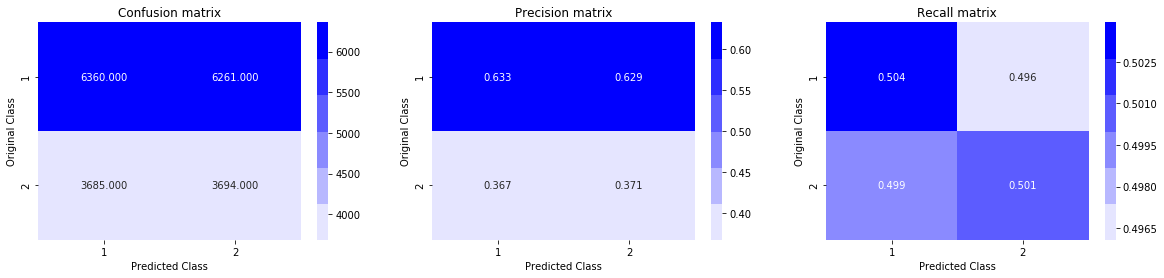

In [78]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

# observation.

- Here we have devloped the random model to predict the log loss.
- The loss here we have is quite high (88%).
- If we see our confusion matrix , precision matrix , and recall matrix we can know how badly our points are missclassified.

# Logistic Regression with hyperparameter tuning on TFIDF Set

For values of alpha =  1e-05 The log loss is: 0.3869204362662778
For values of alpha =  0.0001 The log loss is: 0.3846763343661773
For values of alpha =  0.001 The log loss is: 0.4007728959479137
For values of alpha =  0.01 The log loss is: 0.42306069447049294
For values of alpha =  0.1 The log loss is: 0.46223336672948817
For values of alpha =  1 The log loss is: 0.5088323846406864
For values of alpha =  10 The log loss is: 0.5333663338603611


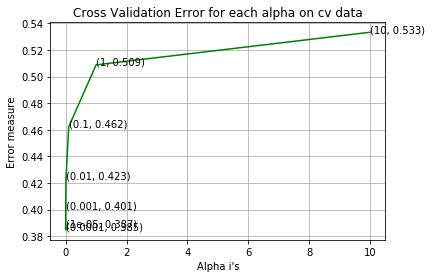

For values of best alpha =  0.0001 The train log loss is: 0.36449287387577567
For values of best alpha =  0.0001 The test log loss is: 0.3794480107992977
Total number of data points : 20000


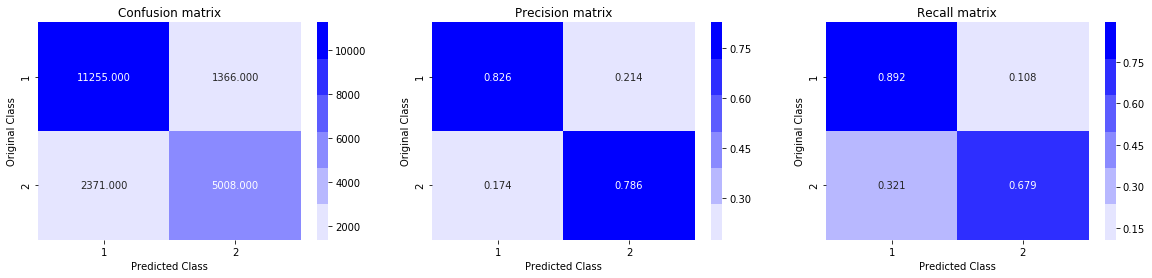

In [79]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_tr, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_tr, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha on cv data")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_tr, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_tr, y_train)

predict_y = sig_clf.predict_proba(X_tr)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_te)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# Observation.

- Here we have used TFIDF data set for the logistic regression model.
- We have also used cv data to find the best hyperparameter to avoid the data leakage
- The log loss on train and test data is 36% and 37% respectively which shows that our model is not overfitted.
- The log loss here on test data is comparitively low then the loss of the random model
- If we look at our confusion matrix there is large number of True positive and True negative data Points.
- For Precision Matrix we can say that Of all the points that are predicted to be of duplicate 82% of the points are actually belong to duplicate class and of all the points predicted to be of non duplicate class is 79 % of points actually belongs to non duplicate question pairs.
- For recall matric we can say that of all the points that actually belong to duplicate class approximately 90% of the points are predected to be of the duplicate class and of all the points that actually belong to non duplicate class  approximately 68 % points are predicted to be of non duplicate class.
- So we can conclude that our logistic regression model is performing quite well.

# Linear SVM with hyperparameter tuning on TfIdf Set

For values of alpha =  1e-05 The log loss is: 0.4177036204734153
For values of alpha =  0.0001 The log loss is: 0.4033418218592401
For values of alpha =  0.001 The log loss is: 0.4215571135168849
For values of alpha =  0.01 The log loss is: 0.43168381347851825
For values of alpha =  0.1 The log loss is: 0.4978429943166438
For values of alpha =  1 The log loss is: 0.6583877778530173
For values of alpha =  10 The log loss is: 0.6583877778530172


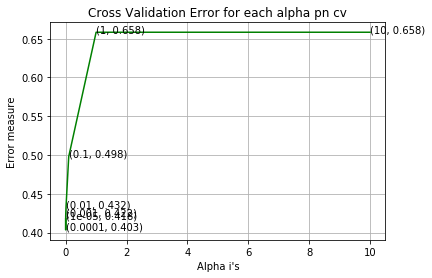

For values of best alpha =  0.0001 The train log loss is: 0.39777574414000866
For values of best alpha =  0.0001 The test log loss is: 0.3992136717169142
Total number of data points : 20000


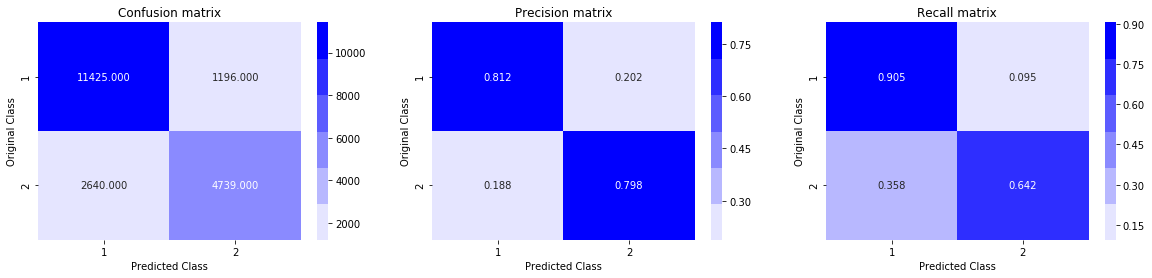

In [80]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_tr, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_tr, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha pn cv")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_tr, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_tr, y_train)

predict_y = sig_clf.predict_proba(X_tr)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_te)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# Observation.

- Here we have used TFIDF data set for the linear svm model.
- We have also used cv data to find the best hyperparameter to avoid the data leakage
- The log loss on train and test data is 39% and 39% respectively which shows that our model is not overfitted.
- The log loss here on test data is comparitively low then the loss of the random model
- If we look at our confusion matrix there is large number of True positive and True negative data Points.
- For Precision Matrix we can say that Of all the points that are predicted to be of duplicate 82% of the points are actually belong to duplicate class and of all the points predicted to be of non duplicate class is 80 % of points actually belongs to non duplicate question pairs.
- For recall matric we can say that of all the points that actually belong to duplicate class approximately 90% of the points are predected to be of the duplicate class and of all the points that actually belong to non duplicate class  approximately 64 % points are predicted to be of non duplicate class.


# Concatinating Features

In [79]:
df1['X_train_cwc_min_stand '] = X_train_cwc_min_stand 
df1['X_train_freq_diff_q1q2_stand'] = X_train_freq_diff_q1q2_stand
df1['X_train_freq_q1q2_stand '] = X_train_freq_q1q2_stand 
df1['X_train_word_share_stand'] = X_train_word_share_stand
df1['X_train_word_Total_stand'] = X_train_word_Total_stand
df1['X_train_word_Common_stand'] = X_train_word_Common_stand
df1['X_train_q2_n_words_stand'] = X_train_q2_n_words_stand
df1['X_train_q1_n_words_stand'] = X_train_q1_n_words_stand
df1['X_train_q2len_stand'] = X_train_q2len_stand 
df1['X_train_q1len_stand '] = X_train_q1len_stand 
df1['X_train_freq_qid2_stand'] = X_train_freq_qid2_stand
df1['X_train_freq_qid1_stand '] = X_train_freq_qid1_stand 
df1['X_train_longest_substr_ratio_stand'] = X_train_longest_substr_ratio_stand
df1['X_train_fuzz_partial_ratio_stand'] = X_train_fuzz_partial_ratio_stand
df1['X_train_fuzz_ratio_stand '] = X_train_fuzz_ratio_stand 
df1['X_train_token_sort_ratio_stand'] = X_train_token_sort_ratio_stand
df1['X_train_token_set_ratio_stand'] = X_train_token_set_ratio_stand
df1['X_train_mean_len_stand '] = X_train_mean_len_stand 
df1['X_train_abs_len_diff_stand'] = X_train_abs_len_diff_stand
df1['X_train_first_word_eq_stand'] = X_train_first_word_eq_stand 
df1['X_train_last_word_eq_stand '] = X_train_last_word_eq_stand 
df1['X_train_ctc_max_stand'] = X_train_ctc_max_stand
df1['X_train_ctc_min_stand'] = X_train_ctc_min_stand
df1['X_train_csc_max_stand'] = X_train_csc_max_stand
df1['X_train_csc_min_stand'] = X_train_csc_min_stand
df1['X_train_cwc_max_stand'] = X_train_cwc_max_stand 



In [80]:
df1_cv_q1['X_cv_cwc_min_stand '] = X_cv_cwc_min_stand 
df1_cv_q1['X_cv_freq_diff_q1q2_stand'] = X_cv_freq_diff_q1q2_stand
df1_cv_q1['X_cv_freq_q1q2_stand '] = X_cv_freq_q1q2_stand 
df1_cv_q1['X_cv_word_share_stand'] = X_cv_word_share_stand
df1_cv_q1['X_cv_word_Total_stand'] = X_cv_word_Total_stand
df1_cv_q1['X_cv_word_Common_stand'] = X_cv_word_Common_stand
df1_cv_q1['X_cv_q2_n_words_stand'] = X_cv_q2_n_words_stand
df1_cv_q1['X_cv_q1_n_words_stand'] = X_cv_q1_n_words_stand
df1_cv_q1['X_cv_q2len_stand'] = X_cv_q2len_stand 
df1_cv_q1['X_cv_q1len_stand '] = X_cv_q1len_stand 
df1_cv_q1['X_cv_freq_qid2_stand'] = X_cv_freq_qid2_stand
df1_cv_q1['X_cv_freq_qid1_stand '] = X_cv_freq_qid1_stand 
df1_cv_q1['X_cv_longest_substr_ratio_stand'] = X_cv_longest_substr_ratio_stand
df1_cv_q1['X_cv_fuzz_partial_ratio_stand'] = X_cv_fuzz_partial_ratio_stand
df1_cv_q1['X_cv_fuzz_ratio_stand '] = X_cv_fuzz_ratio_stand 
df1_cv_q1['X_cv_token_sort_ratio_stand'] = X_cv_token_sort_ratio_stand
df1_cv_q1['X_cv_token_set_ratio_stand'] = X_cv_token_set_ratio_stand
df1_cv_q1['X_cv_mean_len_stand '] = X_cv_mean_len_stand 
df1_cv_q1['X_cv_abs_len_diff_stand'] = X_cv_abs_len_diff_stand
df1_cv_q1['X_cv_first_word_eq_stand'] = X_cv_first_word_eq_stand 
df1_cv_q1['X_cv_last_word_eq_stand '] = X_cv_last_word_eq_stand 
df1_cv_q1['X_cv_ctc_max_stand'] = X_cv_ctc_max_stand
df1_cv_q1['X_cv_ctc_min_stand'] = X_cv_ctc_min_stand
df1_cv_q1['X_cv_csc_max_stand'] = X_cv_csc_max_stand
df1_cv_q1['X_cv_csc_min_stand'] = X_cv_csc_min_stand
df1_cv_q1['X_cv_cwc_max_stand'] = X_cv_cwc_max_stand 

In [81]:
df1_test_q1['X_test_cwc_min_stand '] = X_test_cwc_min_stand 
df1_test_q1['X_test_freq_diff_q1q2_stand'] = X_test_freq_diff_q1q2_stand
df1_test_q1['X_test_freq_q1q2_stand '] = X_test_freq_q1q2_stand 
df1_test_q1['X_test_word_share_stand'] = X_test_word_share_stand
df1_test_q1['X_test_word_Total_stand'] = X_test_word_Total_stand
df1_test_q1['X_test_word_Common_stand'] = X_test_word_Common_stand
df1_test_q1['X_test_q2_n_words_stand'] = X_test_q2_n_words_stand
df1_test_q1['X_test_q1_n_words_stand'] = X_test_q1_n_words_stand
df1_test_q1['X_test_q2len_stand'] = X_test_q2len_stand 
df1_test_q1['X_test_q1len_stand '] = X_test_q1len_stand 
df1_test_q1['X_test_freq_qid2_stand'] = X_test_freq_qid2_stand
df1_test_q1['X_test_freq_qid1_stand '] = X_test_freq_qid1_stand 
df1_test_q1['X_test_longest_substr_ratio_stand'] = X_test_longest_substr_ratio_stand
df1_test_q1['X_test_fuzz_partial_ratio_stand'] = X_test_fuzz_partial_ratio_stand
df1_test_q1['X_test_fuzz_ratio_stand '] = X_test_fuzz_ratio_stand 
df1_test_q1['X_test_token_sort_ratio_stand'] = X_test_token_sort_ratio_stand
df1_test_q1['X_test_token_set_ratio_stand'] = X_test_token_set_ratio_stand
df1_test_q1['X_test_mean_len_stand '] = X_test_mean_len_stand 
df1_test_q1['X_test_abs_len_diff_stand'] = X_test_abs_len_diff_stand
df1_test_q1['X_test_first_word_eq_stand'] = X_test_first_word_eq_stand 
df1_test_q1['X_test_last_word_eq_stand '] = X_test_last_word_eq_stand 
df1_test_q1['X_test_ctc_max_stand'] = X_test_ctc_max_stand
df1_test_q1['X_test_ctc_min_stand'] = X_test_ctc_min_stand
df1_test_q1['X_test_csc_max_stand'] = X_test_csc_max_stand
df1_test_q1['X_test_csc_min_stand'] = X_test_csc_min_stand
df1_test_q1['X_test_cwc_max_stand'] = X_test_cwc_max_stand 

In [82]:
df1['id'] = id1['id']
df1_q2['id'] = id1['id']
df1_cv_q1['id'] = id3['id']
df1_cv_q2['id'] = id3['id']
df1_test_q1['id'] = id2['id']
df1_test_q2['id'] = id2['id']


In [83]:
result_train = df1.merge(df1_q2, on='id',how='left')
result_cv = df1_cv_q1.merge(df1_cv_q2, on='id',how='left')
result_test = df1_test_q1.merge(df1_test_q2, on='id',how='left')

In [84]:
result_train.head()


,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,56.974754,-31.623169,14.776418,-0.879497,-16.202668,-22.032604,-18.037917,1.154812,-24.922027,43.341039,...,-4.656930,-19.022320,37.450969,-1.468994,34.655555,-33.111314,24.439209,42.026902,-15.794651,7.740181
1,176.677225,-213.915146,-14.932039,-158.530595,-90.732114,-8.960324,283.820893,-103.179232,-22.421912,71.075899,...,11.864881,1.155723,68.520517,20.647607,31.184997,6.503763,-32.444098,21.901840,-10.797011,26.748798
2,76.699665,-70.035066,15.191837,-49.940784,-102.144436,-15.694981,22.390395,-25.319034,-16.812109,95.599233,...,71.986844,-19.107353,-39.783336,35.094915,-1.345363,13.028686,-18.535168,31.224399,-15.987473,21.603972
3,136.523648,-15.429150,-85.413874,-150.635408,-59.535120,-15.358825,124.861799,27.504731,-33.183406,71.192452,...,4.009461,1.689686,68.978542,-10.777313,-0.051342,33.925458,-35.751914,22.366190,-59.108962,20.617861
4,22.712608,-53.559079,36.844013,-13.790469,-35.385882,53.793468,52.376090,-28.695078,30.079976,27.908762,...,6.163449,-4.522138,41.387422,101.222317,-21.522653,10.328700,-32.678128,56.437915,-14.072939,-85.813424


In [85]:
result_cv.head()

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,59.687177,-82.273061,11.908227,-18.492747,-67.589800,-11.540278,44.035917,-17.629495,-13.211897,70.882702,...,8.451600,-12.139462,17.375420,6.445427,3.435246,16.036283,-22.060206,24.840993,-30.439044,32.515541
1,81.924910,-87.000760,11.355138,-75.792414,-13.300342,-2.560325,84.524909,-19.990759,-70.252487,11.176174,...,30.863419,-8.158773,72.177979,58.536397,42.248950,-17.825972,-60.228891,30.847685,-107.294236,-12.284249
2,25.193021,-52.508725,-25.021555,10.504304,-4.191151,60.193565,167.123106,86.909073,-46.117676,68.043599,...,11.048149,-21.245236,151.696427,-122.693285,-1.784299,30.453756,-120.060885,-45.401713,-45.241808,56.666076
3,8.606141,-18.577521,31.413889,-2.584588,-0.462524,3.326608,-2.805450,-15.572844,-14.860098,17.238973,...,-8.694702,-26.030514,28.981996,-12.641704,-38.737745,-12.690025,18.404381,-18.834367,2.241466,42.317780
4,14.983792,3.648064,14.873043,-32.074179,39.179834,4.690898,18.077334,17.202317,-22.611732,11.647635,...,-14.801582,-8.643657,46.531338,26.562077,3.045952,-0.975125,-16.685344,9.692618,-32.323268,-35.929474


In [86]:
result_test.head()

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,-30.270423,-39.519523,-108.662220,-81.606903,12.621193,50.149184,33.655077,10.805605,-59.768202,-19.524038,...,63.108465,22.869392,74.774454,33.335279,10.593507,23.344418,39.444022,30.398507,-20.885468,33.360725
1,-26.638857,-14.056952,2.719328,-10.069068,37.250597,8.738672,35.562140,11.153286,13.513415,-2.978835,...,43.435150,16.174818,52.417759,1.162170,-10.586572,-52.836027,-50.135520,18.064565,-22.286919,10.482822
2,21.084538,11.647778,-26.062578,-48.244839,9.380896,-2.737415,1.723608,-1.602966,-10.498632,-13.308736,...,8.152620,-39.365529,83.758715,-17.113093,-22.596804,24.702381,-6.924561,-24.784601,-51.388985,8.102541
3,15.574602,-20.050781,32.887186,-16.266396,-2.622835,5.996462,11.751752,-2.848224,-20.566381,15.435878,...,7.530086,0.227851,1.901548,2.225986,-5.739512,5.360421,-7.408268,1.716194,5.994143,0.925694
4,57.946009,-15.599013,-57.073038,-86.183156,-96.292097,48.682325,30.834947,81.225595,-86.226931,39.658463,...,-12.069812,3.543800,109.199966,42.244495,-11.188801,72.590705,3.350864,16.454384,-111.420812,96.720500


In [87]:
result_train.drop(['id'], axis=1, inplace=True)
result_test.drop(['id'], axis=1, inplace=True)
result_cv.drop(['id'], axis=1, inplace=True)

In [88]:
X_train = result_train.as_matrix()
X_cv = result_cv.as_matrix()
X_test = result_test.as_matrix()

# Applying Random Search to tune the hyperparameters.

In [89]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

In [90]:
import xgboost as xgb 

params = {
        
        'eta':[0.05,0.02,0.01,0.1],
        'max_depth'    : [2,3, 4, 5]
        }
model = XGBClassifier()

random_search = RandomizedSearchCV(model, param_distributions=params,scoring="neg_log_loss", n_iter= 5, n_jobs=-1, cv= 3, verbose=3, random_state=1001 )
random_search.fit(X_train, y_train)
print(random_search.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  2.3min remaining:  6.2min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  2.9min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  4.0min finished


{'max_depth': 5, 'eta': 0.02}


In [100]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 5

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels= clf.classes_, eps=1e-15))

[0]	train-logloss:0.684071	valid-logloss:0.684051
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.609602	valid-logloss:0.609342
[20]	train-logloss:0.555405	valid-logloss:0.555057
[30]	train-logloss:0.514544	valid-logloss:0.514114
[40]	train-logloss:0.483379	valid-logloss:0.483018
[50]	train-logloss:0.459403	valid-logloss:0.459135
[60]	train-logloss:0.440545	valid-logloss:0.440404
[70]	train-logloss:0.425565	valid-logloss:0.425687
[80]	train-logloss:0.413357	valid-logloss:0.413751
[90]	train-logloss:0.403676	valid-logloss:0.40434
[100]	train-logloss:0.395752	valid-logloss:0.396753
[110]	train-logloss:0.388931	valid-logloss:0.390259
[120]	train-logloss:0.383149	valid-logloss:0.384915
[130]	train-logloss:0.378192	valid-logloss:0.380408
[140]	train-logloss:0.373887	valid-logloss:0.376533
[150]	train-logloss:0.370345	valid-logloss:0.373405
[160]	train-logloss:0.367251	

Total number of data points : 20000


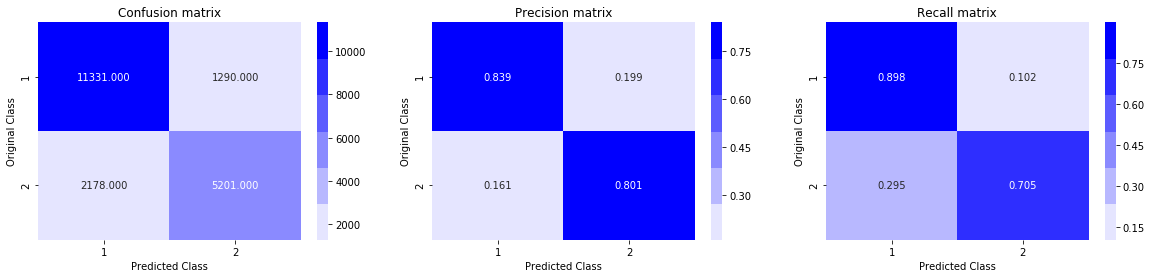

In [101]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# Observation.

- Here we have used avgword2vec TFIDF data set for the Xgboost model.
- We have also used cv data to find the best hyperparameter to avoid the data leakage
- The log loss on train and test data is 34% and 34% respectively which shows that our model is not overfitted.
- The log loss here on test data is comparitively low then the loss of the random model
- If we look at our confusion matrix there is large number of True positive and True negative data Points.
- For Precision Matrix we can say that Of all the points that are predicted to be of duplicate 84% of the points are actually belong to duplicate class and of all the points predicted to be of non duplicate class is 80 % of points actually belongs to non duplicate question pairs.
- For recall matric we can say that of all the points that actually belong to duplicate class approximately 90% of the points are predected to be of the duplicate class and of all the points that actually belong to non duplicate class  approximately 70 % points are predicted to be of non duplicate class.
- So we can conclude that our Xgboost model is better.

In [101]:
from prettytable import PrettyTable

In [105]:
x = PrettyTable()

x.field_names = ['model','Vectoriser','Hyper Parameter','log loss']

In [106]:
x.add_row(['Random model','Tfidf', '-' , 0.88])
x.add_row(['Logistic Regression','TFIDF','alpha - 0.0001',0.37])
x.add_row(['Linear Svm ','TFIDF','alpha - 0.0001',0.39])
x.add_row(['XGboost','TFIDF W2V','max_depth - 5 and eta - 0.02',0.34])

In [107]:
print(x)

+---------------------+------------+------------------------------+----------+
|        model        | Vectoriser |       Hyper Parameter        | log loss |
+---------------------+------------+------------------------------+----------+
|     Random model    |   Tfidf    |              -               |   0.88   |
| Logistic Regression |   TFIDF    |        alpha - 0.0001        |   0.37   |
|     Linear Svm      |   TFIDF    |        alpha - 0.0001        |   0.39   |
|       XGboost       | TFIDF W2V  | max_depth - 5 and eta - 0.02 |   0.34   |
+---------------------+------------+------------------------------+----------+


# Summary.

- Log loss of the random model is the heighest.
- log loss of the XGboost model is the lowest.
- But we can see that except the random model the other three model has performed quite well.
- Xgboost model performance is better than each model.